In [57]:
import os
import numpy as np
import pandas as pd
import pretty_midi


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


# Data Pre-Processing

## Load Files 
We will be loading files in 2 ways: 
- for piano rolls generation
- labeled with features extracted: 
  - `avg_pitch`
  - `std_pitch`
  - `avg_duration` 
  - `std_duration` 
  - `avg_velocity` 
  - `std_velocity` 
  - `note_vector` -  the sequence of note pitches per midi file
  - `duration_vector`  -  the sequence of note durations per midi file 
  - `velocity_vector` - the sequence of note velocities per midi file

In [2]:
# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

composer_dirs = [bach_dir, beethoven_dir, chopin_dir, mozart_dir]

### For CNN

In [3]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add it to the list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

# Print the number of MIDI files for each composer
print(f'Bach MIDI files: {len(bach_midi_files)}')
print(f'Beethoven MIDI files: {len(beethoven_midi_files)}')
print(f'Chopin MIDI files: {len(chopin_midi_files)}')
print(f'Mozart MIDI files: {len(mozart_midi_files)}')

Bach MIDI files: 925
Beethoven MIDI files: 212
Chopin MIDI files: 136
Mozart MIDI files: 257


### For LSTM

In [4]:
def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    # Extract note pitches
    pitches = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)
    
    # Extract note durations
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            durations.append(note.end - note.start)
    
    # Extract note velocities
    velocities = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            velocities.append(note.velocity)
    
    # Compute average and standard deviation for features
    features = {
        'avg_pitch': np.mean(pitches),
        'std_pitch': np.std(pitches),
        'avg_duration': np.mean(durations),
        'std_duration': np.std(durations),
        'avg_velocity': np.mean(velocities),
        'std_velocity': np.std(velocities),
        'note_vector': pitches,  # Add the sequence of note pitches as a feature
        'duration_vector': durations,  # Add the sequence of note durations as a feature
        'velocity_vector': velocities  # Add the sequence of note velocities as a feature
    }
    
    return features


def load_data(directory, current_label, data, success_files, exception_files):
    print(f'Loading {directory} for {current_label}...')
       # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                print(f'Processing {file}...')
                print(f'File path: {file_path}')
                try: 
                    features = extract_features(file_path)
                    features['composer'] = current_label
                    data.append(features)
                    success_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}") 
                    exception_files.append(file_path)

def create_dataframe(data, max_sequence_length = 100):
    df = pd.DataFrame(data)

    df['composer'] = df['composer'].map({0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'})
    df = pd.DataFrame(data)
    
    # Pad sequences to a fixed length
    note_vectors = pad_sequences(df['note_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    duration_vectors = pad_sequences(df['duration_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    velocity_vectors = pad_sequences(df['velocity_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    
    # Add padded sequences to the dataframe
    df['note_vector'] = list(note_vectors)
    df['duration_vector'] = list(duration_vectors)
    df['velocity_vector'] = list(velocity_vectors)
    return df
            
data = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, success_files, exception_files)

# Create dataframe
df = create_dataframe(data)

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Processing Bwv0997 Partita for Lute 1mov.mid...
File path: music_data/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid
Processing Bwv0535 Prelude and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0535 Prelude and Fugue.mid
Processing Bwv0538 Toccata and Fugue Dorian.mid...
File path: music_data/midiclassics/Bach/Bwv0538 Toccata and Fugue Dorian.mid
Processing Bwv0806 English Suite n1 05mov.mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 05mov.mid
Processing Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid...
File path: music_data/midiclassics/Bach/Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid
Processing Jesu Joy of Man Desiring.mid...
File path: music_data/midiclassics/Bach/Jesu Joy of Man Desiring.mid
Processing Prelude and Fugue in C Sharp BWV 872.mid...
File path: music_data/midiclassics/Bach/Prelude and Fugue in C Sharp BWV 872.mid
Processing Bwv0582 Passacaglia and Fugue.mid...
File path: music_dat

/Users/vivianperng/anaconda3/envs/tf/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Bwv0527 Sonate en trio n3.mid...
File path: music_data/midiclassics/Bach/Bwv0527 Sonate en trio n3.mid
Processing Bwv0806 English Suite n1 03mov .mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 03mov .mid
Processing Bwv0560 Short Prelude and Fugue n8 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0560 Short Prelude and Fugue n8 (Spurious).mid
Processing Bwv0811 English Suite n6 2mov.mid...
File path: music_data/midiclassics/Bach/Bwv0811 English Suite n6 2mov.mid
Processing Bwv1005 Violin Sonata n3 3mov Largo.mid...
File path: music_data/midiclassics/Bach/Bwv1005 Violin Sonata n3 3mov Largo.mid
Processing Bwv0559 Short Prelude and Fugue n7 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0559 Short Prelude and Fugue n7 (Spurious).mid
Processing Bwv0556 Short Prelude and Fugue n4 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0556 Short Prelude and Fugue n4 (Spurious).mid
Processing Bwv1014 Harpsicord and Violin S

,avg_pitch,std_pitch,avg_duration,std_duration,avg_velocity,std_velocity,note_vector,duration_vector,velocity_vector,composer
0,67.425793,13.362625,0.317746,0.217394,100.000000,0.000000,"[41, 39, 51, 50, 51, 39, 38, 43, 36, 53, 51, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0
1,65.095977,8.985751,0.331267,0.483278,94.226798,3.158550,"[46, 45, 46, 41, 48, 43, 45, 38, 62, 61, 62, 5...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
2,62.401813,9.737270,0.439333,0.538963,93.416353,3.486757,"[52, 53, 52, 53, 52, 53, 52, 53, 52, 53, 52, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
3,63.708571,12.281183,0.251194,0.257226,107.000000,0.000000,"[57, 57, 45, 38, 50, 49, 47, 49, 50, 47, 46, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[107, 107, 107, 107, 107, 107, 107, 107, 107, ...",0
4,56.748663,9.189533,0.241845,0.475768,97.967914,6.821956,"[48, 46, 48, 41, 44, 48, 41, 43, 45, 46, 38, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0


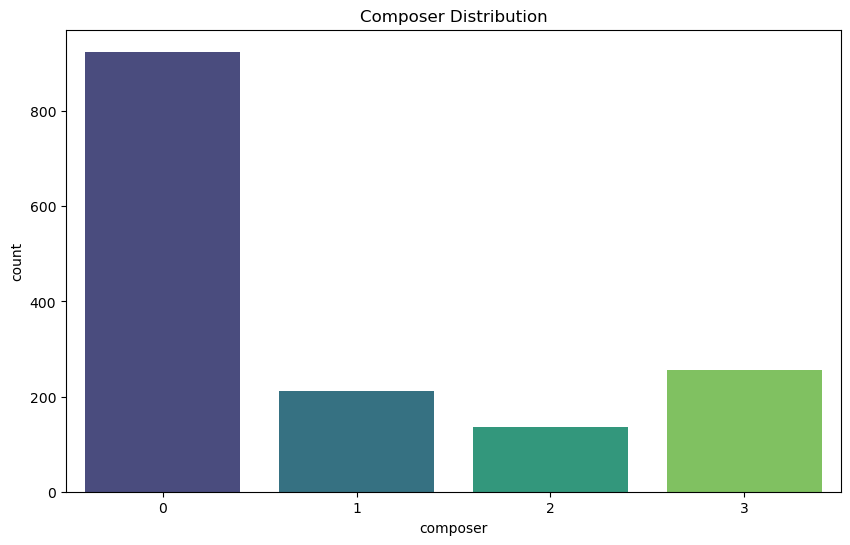

In [5]:
# plot composer distribution, add color for each composer
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer', palette='viridis')
plt.title('Composer Distribution')
plt.show()

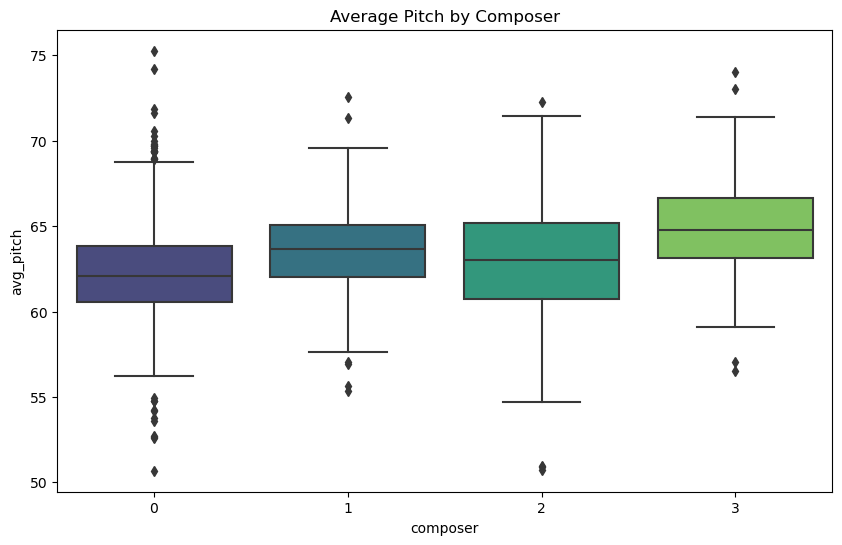

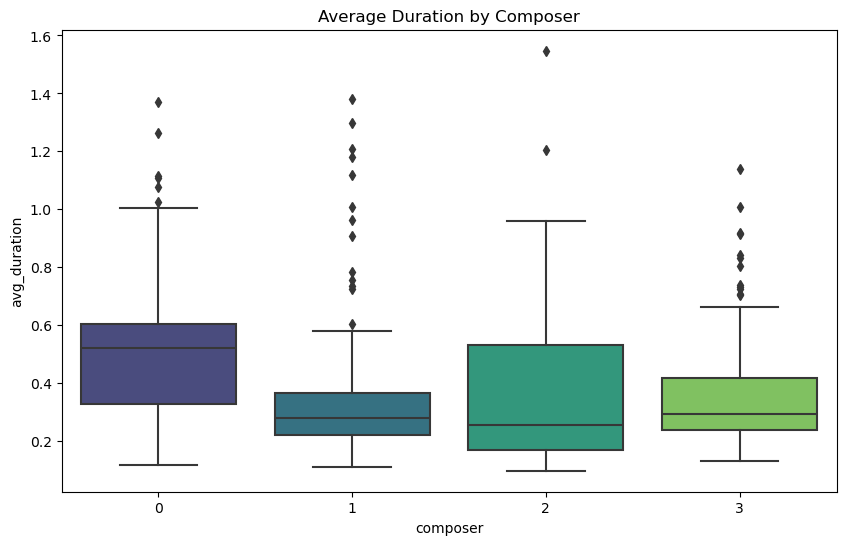

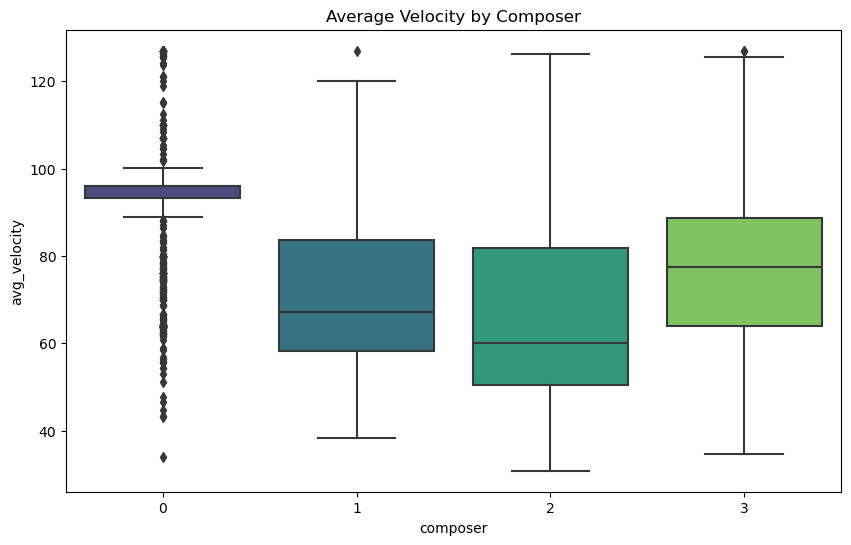

In [6]:
# plot average pitch for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')
plt.title('Average Pitch by Composer')
plt.show()

# plot average duration for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')
plt.title('Average Duration by Composer')
plt.show()

# plot average velocity for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')
plt.title('Average Velocity by Composer')
plt.show()

## Address Class Imbalance 

### For CNN

In [7]:
# Randomly sample 136 MIDI files from each composer
np.random.seed(0)
bach_sample = np.random.choice(bach_midi_files, 136, replace=False)
beethoven_sample = np.random.choice(beethoven_midi_files, 136, replace=False)
chopin_sample = np.random.choice(chopin_midi_files, 136, replace=False)
mozart_sample = np.random.choice(mozart_midi_files, 136, replace=False)

### For LSTM

In [8]:
# Prepare the dataset
X = df.drop(columns=['composer'])
y = df['composer']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use RandomUnderSampler to handle class imbalance
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_encoded)

# Convert resampled data back to DataFrame for easier handling
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name='composer')

# Verify class distribution after undersampling
print(y_resampled_df.value_counts())

composer
0    136
1    136
2    136
3    136
Name: count, dtype: int64


## Feature Extraction 

### For CNN

In [45]:
def save_piano_roll_png(midi_files, subfolder=''):
    """
    This function iterates over each MIDI file in the array of MIDI
    files passed in, converts the MIDI file into a PrettyMIDI object,
    plots the piano roll by using Librosa's specshow function, and then
    saves the image in the composer's folder.
    
    Args:
        midi_files (numpy array): List of midi files
        subfolder (string): Name of folder by composer
    """
    # Iterate over each MIDI file
    for midi_file_path in midi_files:
        try:
            # Convert the MIDI file to a PrettyMIDI object
            pm = pretty_midi.PrettyMIDI(midi_file_path)
            
            # Use librosa's specshow function for displaying the piano roll
            start_pitch = 21
            end_pitch = 108
            librosa.display.specshow(pm.get_piano_roll(50)[start_pitch:end_pitch],
                             hop_length=1, sr=50, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
            
            # Save the figure to a PNG file
            image_path = f'piano_roll_images/{subfolder}/{os.path.basename(midi_file_path)}.png'
            plt.savefig(image_path)
    
        except Exception as e:
            print(f"Skipping file {midi_file_path} due to error: {e}")
            continue


In [11]:
# Execute function to create piano rolls for each Bach Midi file and save png files in folder
# Code is commented out since image files have already been created and does not need to be rerun. Folder of images can be found on GitHub
 
# save_piano_roll_png(bach_sample, subfolder='Bach')

In [12]:
# Execute function to create piano rolls for each Beethoven Midi file and save png files in folder
# Code is commented out since image files have already been created and does not need to be rerun. Folder of images can be found on GitHub

# save_piano_roll_png(beethoven_sample, subfolder='Beethoven')

In [13]:
# Execute function to create piano rolls for each Chopin Midi file and save png files in folder
# Code is commented out since image files have already been created and does not need to be rerun. Folder of images can be found on GitHub

# save_piano_roll_png(chopin_sample, subfolder='Chopin')

In [14]:
# Execute function to create piano rolls for each Mozart Midi file and save png files in folder
# Code is commented out since image files have already been created and does not need to be rerun. Folder of images can be found on GitHub

# save_piano_roll_png(mozart_sample, subfolder='Mozart')

In [47]:
def create_df(directory, composer):
    """
    This function creates a pandas DataFrame containing the names of
    all files in a specified directory and associates each file with
    a specified composer.

    Args:
    directory (str): The path to the directory containing the files.
    composer (str): The name of the composer to associate with each file.

    Returns:
    df (pandas.DataFrame): A DataFrame where each row represents a file. The DataFrame has two columns: 'image_id', which contains the file names, and 'composer', which contains the composer associated with each file.
    """
    # Get a list of all file names in the directory
    file_names = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    # Create a list with the composer name repeated for each image
    labels = [composer] * len(file_names)
    
    # Create a DataFrame with the image ids and composers
    df = pd.DataFrame({
        'image_id': file_names,
        'composer': labels
    })
    
    return df

In [48]:
# Execute function to create dataframe with all the image IDs for Bach
bach_pr_df = create_df('piano_roll_images/Bach', 'bach')
print(bach_pr_df.head())

                                   image_id composer
0                          028000b_.mid.png     bach
1                          034100b_.mid.png     bach
2                          024526b_.mid.png     bach
3  Bwv1066 Orchestral Suite n1 2mov.mid.png     bach
4                      Variation 24.mid.png     bach


In [49]:
# Execute function to create dataframe with all the image IDs for Beethoven
beethoven_pr_df = create_df('piano_roll_images/Beethoven', 'beethoven')
print(beethoven_pr_df.head())

                                            image_id   composer
0              Piano Sonata n18 ''The Hunt''.mid.png  beethoven
1  Sieben Bagatellen, in D Major, Opus.33, No.6.m...  beethoven
2                          Sechs Variationen.mid.png  beethoven
3                 Overture ''Fidelio'' op72b.mid.png  beethoven
4  Sieben Bagatellen, C Major, Opus.33, No.2.mid.png  beethoven


In [50]:
# Execute function to create dataframe with all the image IDs for Bach
chopin_pr_df = create_df('piano_roll_images/Chopin', 'chopin')
print(chopin_pr_df.head())

                                            image_id composer
0                           Nocturne op37 01.mid.png   chopin
1  19 Polish Songs, for Solo Voice and Piano acco...   chopin
2         Polonaise Opus.40, No.1 (Military).mid.png   chopin
3                    Fantasie Impromptu op66.mid.png   chopin
4                Piano Concerto n1 op11 2mov.mid.png   chopin


In [51]:
# Execute function to create dataframe with all the image IDs for Bach
mozart_pr_df = create_df('piano_roll_images/Mozart', 'mozart')
print(mozart_pr_df.head())

                                         image_id composer
0      Symphony n41 K551 2mov ''Jupiter''.mid.png   mozart
1              K626 Requiem 06 confutatis.mid.png   mozart
2  K626 Requiem 08 offertorio domine jesu.mid.png   mozart
3              K333 Piano Sonata n13 1mov.mid.png   mozart
4                Early Pieces n12 Rondino.mid.png   mozart


In [52]:
# Concatenate each composer's dataframe and reset the index
pianorolls_df = pd.concat([bach_pr_df, beethoven_pr_df, chopin_pr_df, mozart_pr_df])
pianorolls_df = pianorolls_df.reset_index(drop=True)

print(pianorolls_df.head())
print(pianorolls_df.tail())

                                   image_id composer
0                          028000b_.mid.png     bach
1                          034100b_.mid.png     bach
2                          024526b_.mid.png     bach
3  Bwv1066 Orchestral Suite n1 2mov.mid.png     bach
4                      Variation 24.mid.png     bach
                                     image_id composer
538            Symphony n33 K319 1mov.mid.png   mozart
539         K317 Coronation Mass 1mov.mid.png   mozart
540                 Sonatina n21 3mov.mid.png   mozart
541            Symphony n28 K200 4mov.mid.png   mozart
542  Symphony n31 K297 1mov ''Paris''.mid.png   mozart


### CNN Data pre-processing

In [53]:
# Initialize empty lists to store the piano roll images and labels
pianorolls = []
composers = []

# Iterate over each row in the dataframe
for index, row in pianorolls_df.iterrows():
    
    # Open the image file
    img = Image.open(f"piano_roll_images/all-piano-rolls/{row['image_id']}")
    
    # Resize the image to 32 x 32 pixels
    img = img.resize((32,32))
    
    # Normalize the pixel values to be between 0 and 1
    img = np.array(img)/255.0
    
    # Append to list of piano roll images
    pianorolls.append(img)
    
    # Append the composer of the image to the composers list
    composers.append(row['composer'])
    
# Convert the lists to numpy arrays
pianorolls = np.array(pianorolls)
composers = np.array(composers)
    
    
    

In [58]:
# Use one-hot encoding to convert string labels to integers
encoder = LabelEncoder()
encoder.fit(composers)
one_hot_composer = encoder.transform(composers)

# Convert the composers to binary class matrices
labels = to_categorical(one_hot_composer)

In [59]:
# Print shapes
print(pianorolls.shape)
print(labels.shape)

(543, 32, 32, 4)
(543, 4)


In [ ]:
# Split the dataset into training, validation, and test set
# 80% training, 10% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(pianorolls,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=15)

### For LSTM 

In [117]:
# Extract and reshape the sequence features for LSTM
note_vectors = np.stack(X_resampled_df['note_vector'].values)
duration_vectors = np.stack(X_resampled_df['duration_vector'].values)
velocity_vectors = np.stack(X_resampled_df['velocity_vector'].values)

# Combine the features into a single 3D array
X_lstm = np.stack((note_vectors, duration_vectors, velocity_vectors), axis=-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_resampled, test_size=0.2, random_state=42)

# Model Building

### CNN

### LSTM

In [118]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Model Training

### CNN

### LSTM

In [119]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3460 - loss: 1.3345 - val_accuracy: 0.5057 - val_loss: 1.1912
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4412 - loss: 1.1696 - val_accuracy: 0.5057 - val_loss: 1.0790
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5421 - loss: 1.0933 - val_accuracy: 0.4713 - val_loss: 1.0265
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5161 - loss: 1.0295 - val_accuracy: 0.4828 - val_loss: 0.9851
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5714 - loss: 0.9910 - val_accuracy: 0.4828 - val_loss: 1.0401
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5584 - loss: 0.9716 - val_accuracy: 0.5172 - val_loss: 1.0373
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6197 - loss: 0.9308 - val_accuracy: 0.5172 - val_loss: 0.9960
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6111 - loss: 0.9584 - val_accuracy: 0.5402 - v

# Model Evaluation

# Model Optimization